In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, precision_score, confusion_matrix, classification_report, make_scorer

from catboost import CatBoostClassifier, Pool

import itertools

### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [2]:
data = pd.read_csv('../lesson_5/materials/churn_data.csv')

In [3]:
print(data.shape)
data.head(3)

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column]
    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        self.columns = [column for column in pd.get_dummies(X, prefix=self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [column for column in self.columns]
        
        for column in self.columns:
            if column not in self.columns:
                X[column] = 0
                
        return X[self.columns]

In [6]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
final_transformers = []

for cat_column in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_column)), 
        ('ohe', OHEEncoder(key=cat_column))
    ])
    final_transformers.append((cat_column, cat_transformer))
    
for cont_column in continuous_columns:
    cont_transformer = Pipeline([('selector', NumberSelector(key=cont_column))])
    final_transformers.append((cont_column, cont_transformer))

In [9]:
feats = FeatureUnion(final_transformers)

pipeline_log_reg = Pipeline([
    ('feats', feats),
    ('log_reg', LogisticRegression())
])

pipeline_classifier = Pipeline([
    ('feats', feats),
    ('catboost_classifier', CatBoostClassifier(iterations=20, random_state=42, silent=True))
])

In [10]:
pipeline_log_reg.fit(X_train, y_train)
pipeline_classifier.fit(X_train, y_train)

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
              

In [11]:
preds_log_reg = pipeline_log_reg.predict_proba(X_test)[:, 1]
preds_classifier = pipeline_classifier.predict_proba(X_test)[:, 1]

In [12]:
def best_metrics(y_true, y_preds):
    precision, recall, thresholds = precision_recall_curve(y_true, y_preds)

    fscore = (2 * precision * recall) / (precision + recall + 1e-9)
    i_x = np.argmax(fscore)
    
    metrics = [thresholds[i_x], fscore[i_x], precision[i_x], recall[i_x]]
    
    return metrics

In [13]:
final_metrics = []

final_metrics.append(best_metrics(y_test, preds_log_reg))
final_metrics.append(best_metrics(y_test, preds_classifier))

metrics_df = pd.DataFrame(final_metrics, 
                          columns=['thresholds', 'fscore', 'precision', 'recall'], 
                          index=['log_reg', 'catboost_classifier'])
metrics_df

,thresholds,fscore,precision,recall
log_reg,0.225384,0.384143,0.285004,0.589041
catboost_classifier,0.319714,0.632636,0.618658,0.647260


In [14]:
metrics_df['thresholds'][1]

0.3197142778659537

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2183  233]
 [ 207  377]]


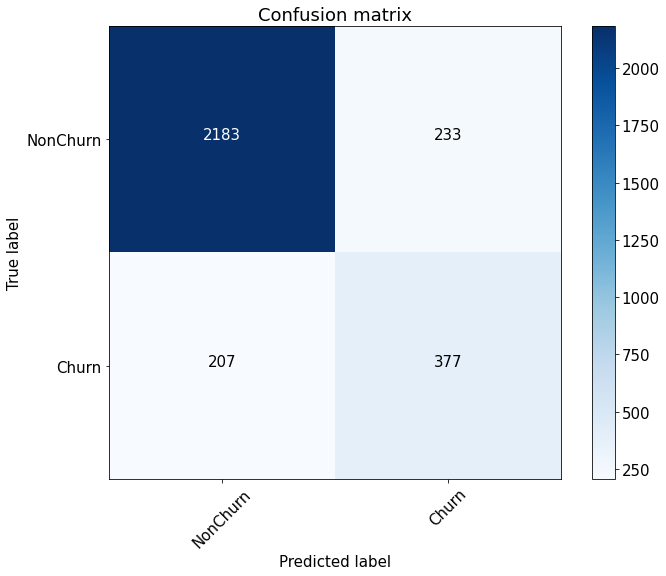

In [16]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_classifier>metrics_df['thresholds'][1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Кажется что лучшая метрика для такой задачи является максимизация precision. Т.к. если мы предсказываем что пользователь уйдет, а он не уходит, то мы теряем с каждого такого пользователя 1 доллар, тогда как с правильно  классифированного зарабатываем 1 доллар.  

### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_classifier>metrics_df['thresholds'][1]).ravel()

In [18]:
income = tp * 2 - fp * 1
income

521

4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [37]:
# model = CatBoostClassifier(loss_function = 'Logloss' , cat_features=categorical_columns + ['Surname'], silent=True)
params = {'classifier__iterations': [15, 20, 25], 
          'classifier__depth': [5, 6, 7],
          'classifier__l2_leaf_reg': np.logspace(-1, -30, 10), 
          'classifier__leaf_estimation_iterations': [5, 10, 15]
         }
# grid_search_result = model.grid_search(params, X_train, y_train)

In [38]:
# best_params = grid_search_result['params']
# best_params


In [39]:
best_pipline_classifier = Pipeline([
    ('feats', feats),
    ('classifier', CatBoostClassifier(random_state=42, silent=True))
])

In [40]:
search = GridSearchCV(best_pipline_classifier, param_grid=params)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('feats',
                                        FeatureUnion(transformer_list=[('Geography',
                                                                        Pipeline(steps=[('selector',
                                                                                         FeatureSelector(column='Geography')),
                                                                                        ('ohe',
                                                                                         OHEEncoder(key='Geography'))])),
                                                                       ('Gender',
                                                                        Pipeline(steps=[('selector',
                                                                                         FeatureSelector(column='Gender')),
                                                                                        ('ohe',
                 

In [41]:
best_params = search.best_params_
params_names = [i.split('__')[1] for i in list(best_params.keys())]
params_values = list(best_params.values())
best_params = dict(zip(params_names, params_values))

In [42]:
best_pipline_classifier = Pipeline([
    ('feats', feats),
    ('classifier', CatBoostClassifier(**best_params, random_state=42, silent=True))
])

In [43]:
best_pipline_classifier.fit(X_train, y_train)

best_preds = best_pipline_classifier.predict_proba(X_test)[:, 1]

5. (опционально) Еще раз провести оценку экономической эффективности

In [44]:
threshold, fscore, precision, recall = best_metrics(y_test, best_preds)

tn, fp, fn, tp = confusion_matrix(y_test, best_preds>threshold).ravel()

income = tp * 2 - fp * 1
income

497